# Conference Comparison Matrix
- create visualization of conference vs conference heatmap

## Setup

In [11]:
import pandas as pd
import numpy as np
import os
import sys

# Load Schedult/results data and compare conferences
path = os.path.join('..', 'data', 'schedule', 'Week 1 Scores.csv')

# Load the data
schedule_df = pd.read_csv(path)

# filter out exhibition games
schedule_df = schedule_df[schedule_df['Conference'] != 'Exhibition']
# Clean up Team names (remove ' and periods)
schedule_df['Away_Team'] = schedule_df['Away_Team'].str.replace("'", "").str.replace(".", "")
schedule_df['Home_Team'] = schedule_df['Home_Team'].str.replace("'", "").str.replace(".", "")
# strip leading and trailing spaces
schedule_df['Away_Team'] = schedule_df['Away_Team'].str.strip()
schedule_df['Home_Team'] = schedule_df['Home_Team'].str.strip()
# Drop any rows containing a / or TBD
schedule_df = schedule_df[~schedule_df['Away_Team'].str.contains('/')]
schedule_df = schedule_df[~schedule_df['Home_Team'].str.contains('/')]
schedule_df = schedule_df[~schedule_df['Away_Team'].str.contains('TBD')]
schedule_df = schedule_df[~schedule_df['Home_Team'].str.contains('TBD')]

## Men's D1

#### Backend

In [12]:
# Define the conferences
conference_teams = {
    'Atlantic': ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
                 'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart'],
    'Big Ten': ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin'],
    'CCHA': ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
             'Minnesota State', 'Northern Michigan', 'St Thomas'],
    'ECAC': ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
             'Rensselaer', 'St Lawrence', 'Union', 'Yale'],
    'Hockey East': ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                    'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont'],
    'NCHC': ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 
             'St Cloud State', 'Western Michigan'],
    'Independents': ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']
}

# Function to get the conference of a team
def get_conference(team):
    for conference, teams in conference_teams.items():
        if team in teams:
            return conference
    return 'Unknown'  # For teams not in the provided lists

# Add columns for conference of both the away and home teams
schedule_df['Away_Conference'] = schedule_df['Away_Team'].apply(get_conference)
schedule_df['Home_Conference'] = schedule_df['Home_Team'].apply(get_conference)

# Drop rows with Unknown conferences - Stonehill and Long Island annonmaly
schedule_df = schedule_df[schedule_df['Away_Conference'] != 'Unknown']
schedule_df = schedule_df[schedule_df['Home_Conference'] != 'Unknown']

# Rename to completed_games_df
completed_games_df = schedule_df

# Matrix for away team wins
away_wins_matrix = pd.crosstab(index=completed_games_df['Away_Conference'],
                               columns=completed_games_df['Home_Conference'],
                               values=(completed_games_df['Away_Score'] > completed_games_df['Home_Score']).astype(int),
                               aggfunc='sum', dropna=False)

# Matrix for home team wins
home_wins_matrix = pd.crosstab(index=completed_games_df['Home_Conference'],
                               columns=completed_games_df['Away_Conference'],
                               values=(completed_games_df['Home_Score'] > completed_games_df['Away_Score']).astype(int),
                               aggfunc='sum', dropna=False)

# Transpose the home wins matrix so that it aligns with the away wins matrix for summation
home_wins_matrix = home_wins_matrix.T

# Sum both matrices to get the total wins
total_wins_matrix = away_wins_matrix.add(home_wins_matrix, fill_value=0)
# total_wins_matrix = total_wins_matrix.astype(int) # Convert to integers

# Rename for Plotting code
out_of_conference_matrix = total_wins_matrix.copy()


# Display the results matrix
print(total_wins_matrix)
# calculate and print the total number of games played
total_games = total_wins_matrix.sum().sum()
print(f'Total games played: {total_games}')


Home_Conference  Atlantic  Big Ten  CCHA  ECAC  Hockey East  Independents  \
Away_Conference                                                             
Atlantic                0        0     0     5            2             0   
Big Ten                 0        0     2     0            0             2   
CCHA                    2        2     1     0            0             0   
ECAC                    0        0     0     0            2             0   
Hockey East             1        0     0     0            0             0   
Independents            0        0     0     0            1             0   
NCHC                    2        0     1     0            0             2   

Home_Conference  NCHC  
Away_Conference        
Atlantic            0  
Big Ten             0  
CCHA                1  
ECAC                0  
Hockey East         0  
Independents        0  
NCHC                0  
Total games played: 26


#### Output Viz

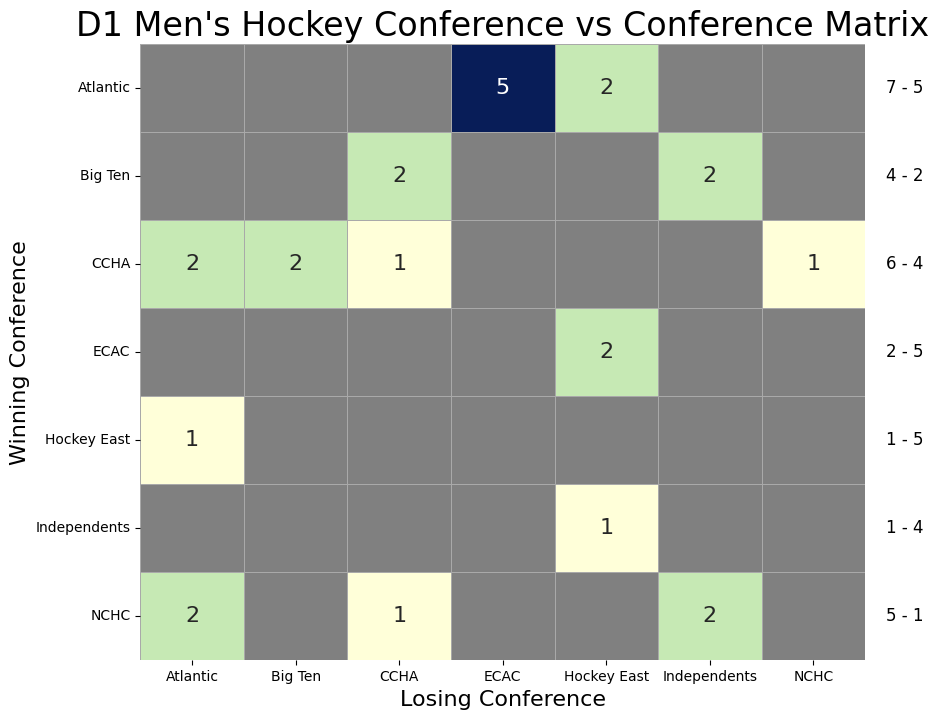

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

color_map = 'YlGnBu'  # Choose a color map for the heatmap

# Assuming you already have your 'total_wins_matrix' and 'out_of_conference_matrix' ready

# Calculate the overall out-of-conference wins for each conference
overall_out_of_conference_wins = out_of_conference_matrix.sum(axis=1)

# Calculate the total losses (opponent wins) for each conference
overall_out_of_conference_losses = out_of_conference_matrix.sum(axis=0)

# Prepare the win-loss record in "wins - losses" format
overall_record = overall_out_of_conference_wins.astype(int).astype(str) + ' - ' + overall_out_of_conference_losses.astype(int).astype(str)

# Mask 0s in the matrix
mask = out_of_conference_matrix == 0

# Create the heatmap
plt.figure(figsize=(10, 8))

# Plot the heatmap without zero values (masked)
ax = sns.heatmap(out_of_conference_matrix,
                 annot=True, fmt='d', 
                 cmap=color_map, linewidths=.5, 
                 cbar=False,  # Remove the color bar
                 mask=mask,  # Mask the zero values
                 annot_kws={"size": 16})  # Adjust annotation font size

# Overlay only the zero cells with a gray color
ax.pcolormesh(np.where(mask, 1, np.nan), cmap=ListedColormap(['gray']), edgecolors='darkgray', linewidth=0.5)

# Add space on the right side to fit the overall record annotations
plt.subplots_adjust(right=0.85)

# Add the overall record (win-loss format) to the right side of the heatmap
for idx, label in enumerate(overall_record):
    # Position the text to the right of the heatmap
    ax.text(out_of_conference_matrix.shape[1] + 0.2, idx + 0.5,  # Adjust horizontal and vertical alignment
            label, va='center', ha='left', fontsize=12, color='black')

# Add labels and titles
ax.set_xlabel('Losing Conference', fontdict={'fontsize': 16})
ax.set_ylabel('Winning Conference', fontdict={'fontsize': 16})
plt.title("D1 Men's Hockey Conference vs Conference Matrix", fontdict={'fontsize': 24})

# Show the plot
plt.show()


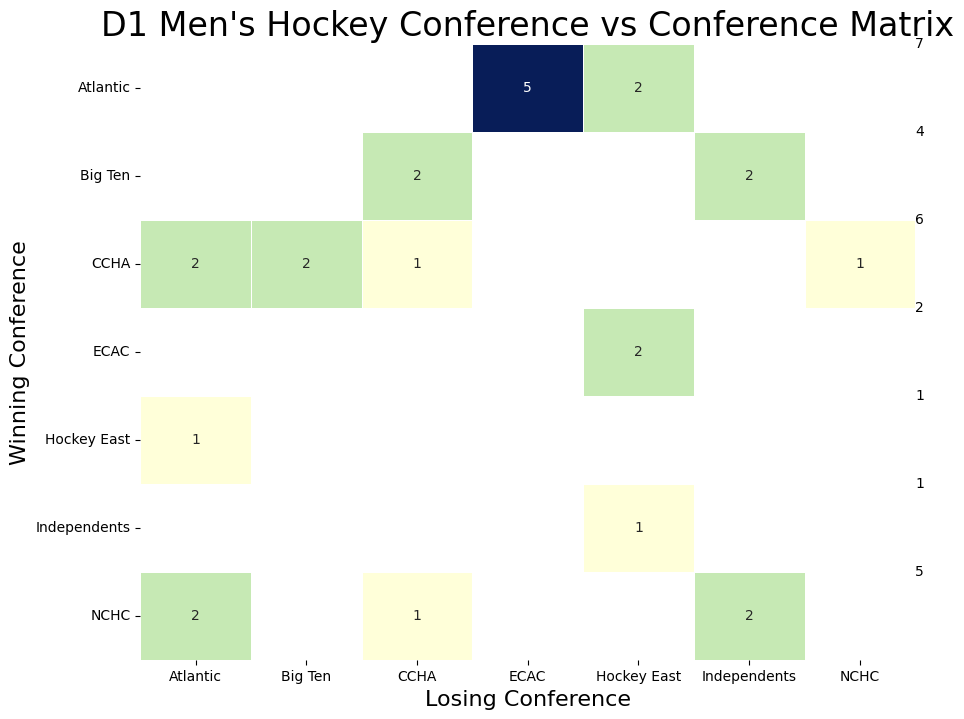

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have your 'total_wins_matrix' and 'out_of_conference_matrix' ready

# Calculate the overall out-of-conference wins for each conference
overall_out_of_conference_wins = out_of_conference_matrix.sum(axis=1)

# Mask 0s in the matrix
mask = out_of_conference_matrix == 0

# Create the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(out_of_conference_matrix,
                 annot=True, fmt='d', 
                 cmap="YlGnBu", linewidths=.5, 
                #  cbar_kws={'label': 'Number of Wins'}, # Color Scale Label
                cbar = False, # Remove the color scale
                 mask=mask)

# Add the overall record (total out-of-conference wins) as annotations to the right side of the heatmap
for idx, label in enumerate(overall_out_of_conference_wins):
    ax.text(out_of_conference_matrix.shape[1], idx, f'{label:.0f}', va='center', ha='left', color='black')

# Add labels and titles
ax.set_xlabel('Losing Conference', fontdict={'fontsize': 16})
ax.set_ylabel('Winning Conference', fontdict={'fontsize': 16})
plt.title("D1 Men's Hockey Conference vs Conference Matrix", fontdict={'fontsize': 24})

# # Add space for the overall record column
# plt.subplots_adjust(right=0.75)

# Remove cmap scale title
cbar = ax.collections[0].colorbar


# Show the plot
plt.show()


AttributeError: QuadMesh.set() got an unexpected keyword argument 'na_color'

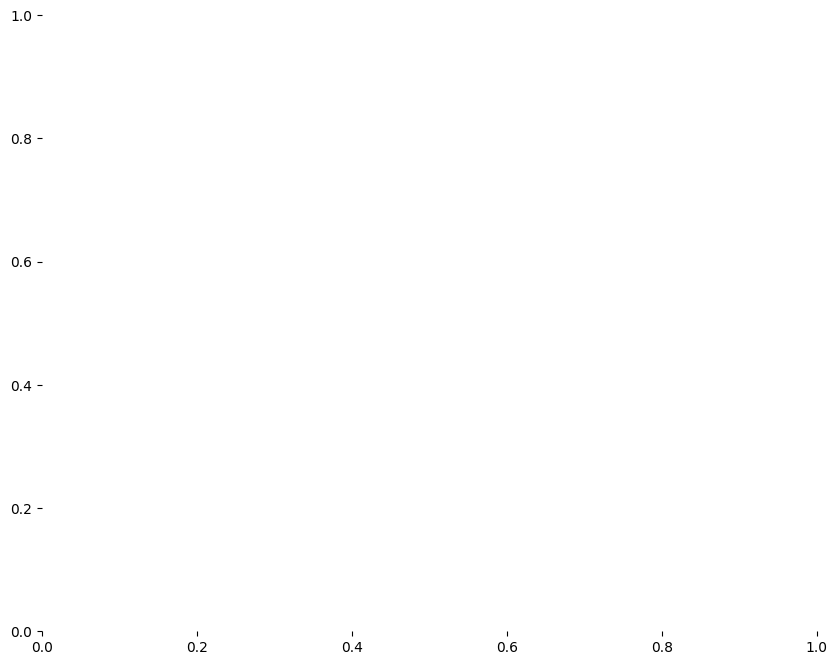

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
# Assuming you already have your 'total_wins_matrix' and 'out_of_conference_matrix' ready

# Calculate the overall out-of-conference wins for each conference
overall_out_of_conference_wins = out_of_conference_matrix.sum(axis=1)

# Calculate the total losses (opponent wins) for each conference
overall_out_of_conference_losses = out_of_conference_matrix.sum(axis=0)

# Prepare the win-loss record in "wins - losses" format
overall_record = overall_out_of_conference_wins.astype(int).astype(str) + ' - ' + overall_out_of_conference_losses.astype(int).astype(str)

# Mask 0s in the matrix
mask = out_of_conference_matrix == 0

# Create the heatmap
plt.figure(figsize=(10, 8))

# Plot the heatmap with a mask for zeros and set the background color for masked cells to dark gray
ax = sns.heatmap(out_of_conference_matrix,
                 annot=True, fmt='d', 
                 cmap="YlGnBu", linewidths=.5, 
                 cbar=False,  # Remove the color bar
                 mask=mask,  # Mask the zero values
                 annot_kws={"size": 12},  # Adjust annotation font size
                 na_color='gray')  # Set the background color for masked cells to dark gray

# Add space on the right side to fit the overall record annotations
plt.subplots_adjust(right=0.85)

# Add the overall record (win-loss format) to the right side of the heatmap
for idx, label in enumerate(overall_record):
    # Position the text to the right of the heatmap
    ax.text(out_of_conference_matrix.shape[1] + 0.2, idx + 0.5,  # Adjust horizontal and vertical alignment
            label, va='center', ha='left', fontsize=12, color='black')

# Add labels and titles
ax.set_xlabel('Losing Conference', fontdict={'fontsize': 16})
ax.set_ylabel('Winning Conference', fontdict={'fontsize': 16})
plt.title("D1 Men's Hockey Conference vs Conference Matrix", fontdict={'fontsize': 24})

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Assuming you already have your 'total_wins_matrix' and 'out_of_conference_matrix' ready

# Calculate the overall out-of-conference wins for each conference
overall_out_of_conference_wins = out_of_conference_matrix.sum(axis=1)

# Calculate the total losses (opponent wins) for each conference
overall_out_of_conference_losses = out_of_conference_matrix.sum(axis=0)

# Prepare the win-loss record in "wins - losses" format
overall_record = overall_out_of_conference_wins.astype(int).astype(str) + ' - ' + overall_out_of_conference_losses.astype(int).astype(str)

# Mask 0s in the matrix
mask = out_of_conference_matrix == 0

# Create the heatmap
plt.figure(figsize=(10, 8))

# Create a custom colormap with dark gray for 0 values and the default 'YlGnBu' colormap for other values
cmap = ListedColormap(["#404040"] + sns.color_palette("YlGnBu", as_cmap=False))

# Plot the heatmap with the custom colormap
ax = sns.heatmap(out_of_conference_matrix,
                 annot=True, fmt='d', 
                 cmap=cmap, linewidths=.5, 
                 cbar=False,  # Remove the color bar
                 mask=mask,  # Mask the zero values
                 annot_kws={"size": 16})  # Adjust annotation font sizee

# Add space on the right side to fit the overall record annotations
plt.subplots_adjust(right=0.85)

# Add the overall record (win-loss format) to the right side of the heatmap
for idx, label in enumerate(overall_record):
    # Position the text to the right of the heatmap
    ax.text(out_of_conference_matrix.shape[1] + 0.2, idx + 0.5,  # Adjust horizontal and vertical alignment
            label, va='center', ha='left', fontsize=12, color='black')

# Add labels and titles
ax.set_xlabel('Losing Conference', fontdict={'fontsize': 16})
ax.set_ylabel('Winning Conference', fontdict={'fontsize': 16})
plt.title("D1 Men's Hockey Conference vs Conference Matrix", fontdict={'fontsize': 24})

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have your 'total_wins_matrix' and 'out_of_conference_matrix' ready

# Calculate the overall out-of-conference wins for each conference
overall_out_of_conference_wins = out_of_conference_matrix.sum(axis=1)

# Calculate the total losses (opponent wins) for each conference
overall_out_of_conference_losses = out_of_conference_matrix.sum(axis=0)

# Prepare the win-loss record in "wins - losses" format
overall_record = overall_out_of_conference_wins.astype(int).astype(str) + ' - ' + overall_out_of_conference_losses.astype(int).astype(str)

# Mask 0s in the matrix
mask = out_of_conference_matrix == 0

# Create the heatmap
plt.figure(figsize=(10, 8))

# Plot the heatmap with a mask for zeros
ax = sns.heatmap(out_of_conference_matrix,
                 annot=True, fmt='d', 
                 cmap="YlGnBu", linewidths=.5, 
                 cbar=False,  # Remove the color bar
                 mask=mask)

# Add space on the right side to fit the overall record annotations
plt.subplots_adjust(right=0.85)

# Add the overall record (win-loss format) to the right side of the heatmap
for idx, label in enumerate(overall_record):
    # Position the text to the right of the heatmap
    ax.text(out_of_conference_matrix.shape[1] + 0.2, idx + 0.5,  # Adjust horizontal and vertical alignment
            label, va='center', ha='left', fontsize=12, color='black')

# Add labels and titles
ax.set_xlabel('Losing Conference', fontdict={'fontsize': 16})
ax.set_ylabel('Winning Conference', fontdict={'fontsize': 16})
plt.title("D1 Men's Hockey Conference vs Conference Matrix", fontdict={'fontsize': 24})

# Show the plot
plt.show()



In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming you already have your 'total_wins_matrix' and 'out_of_conference_matrix' ready

# # Calculate the overall out-of-conference wins for each conference
# overall_out_of_conference_wins = out_of_conference_matrix.sum(axis=1)

# # Mask 0s in the matrix
# mask = out_of_conference_matrix == 0

# # Create the heatmap
# plt.figure(figsize=(10, 8))

# # Plot the heatmap with a mask for zeros
# ax = sns.heatmap(out_of_conference_matrix,
#                  annot=True, fmt='d', 
#                  cmap="YlGnBu", linewidths=.5, 
#                  cbar=False,  # Remove the color bar
#                  mask=mask)

# # Add space on the right side to fit the overall record annotations
# plt.subplots_adjust(right=0.85)

# # Add the overall record (total out-of-conference wins) as annotations to the right side of the heatmap
# for idx, label in enumerate(overall_out_of_conference_wins):
#     # Position the text to the right of the heatmap
#     ax.text(out_of_conference_matrix.shape[1] + 0.2, idx + 0.5,  # Adjust horizontal and vertical alignment
#             f'{label:.0f}', va='center', ha='left', fontsize=12, color='black')

# # Add labels and titles
# ax.set_xlabel('Losing Conference', fontdict={'fontsize': 16})
# ax.set_ylabel('Winning Conference', fontdict={'fontsize': 16})
# plt.title("D1 Men's Hockey Conference vs Conference Matrix", fontdict={'fontsize': 24})

# # Show the plot
# plt.show()
